# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

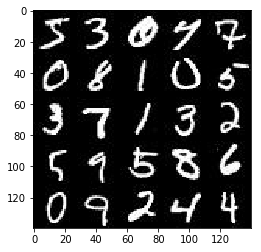

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

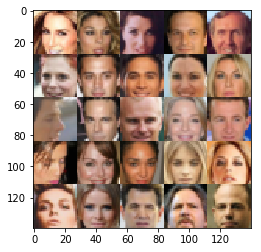

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_img = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_img')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')
    return input_img, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """


    initializer=tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer = initializer)
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer = initializer)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        dropout2 = tf.layers.dropout(inputs=bn2, rate=0.5,training=True, name="dropout2")
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer = initializer)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        dropout3 = tf.layers.dropout(inputs=bn3, rate=0.5,training=True, name="dropout3")
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    initializer=tf.contrib.layers.xavier_initializer()

    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512,kernel_initializer = initializer)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', kernel_initializer = initializer)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same', kernel_initializer = initializer)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same', kernel_initializer = initializer)
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1.0 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    input_img, input_z, learning_rate_ph = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    d_loss, g_loss = model_loss(input_img, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
    
    steps, print_every, show_every = 0, 10, 100  
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_img: batch_images, input_z: batch_z, learning_rate_ph: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_img: batch_images, input_z: batch_z, learning_rate_ph: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_img: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.3925... Generator Loss: 0.3418
Epoch 1/2... Discriminator Loss: 0.6792... Generator Loss: 3.7168
Epoch 1/2... Discriminator Loss: 1.3210... Generator Loss: 1.2844
Epoch 1/2... Discriminator Loss: 1.1877... Generator Loss: 0.9049
Epoch 1/2... Discriminator Loss: 0.9891... Generator Loss: 2.5488
Epoch 1/2... Discriminator Loss: 1.3445... Generator Loss: 0.7676
Epoch 1/2... Discriminator Loss: 1.4899... Generator Loss: 0.6845
Epoch 1/2... Discriminator Loss: 2.2306... Generator Loss: 2.7580
Epoch 1/2... Discriminator Loss: 1.3429... Generator Loss: 1.0257
Epoch 1/2... Discriminator Loss: 1.3734... Generator Loss: 0.5281


Epoch 1/2... Discriminator Loss: 1.3754... Generator Loss: 0.5554
Epoch 1/2... Discriminator Loss: 1.7177... Generator Loss: 0.3691
Epoch 1/2... Discriminator Loss: 1.3462... Generator Loss: 0.7471
Epoch 1/2... Discriminator Loss: 1.6235... Generator Loss: 0.3862
Epoch 1/2... Discriminator Loss: 1.3517... Generator Loss: 0.6452
Epoch 1/2... Discriminator Loss: 1.7070... Generator Loss: 1.5227
Epoch 1/2... Discriminator Loss: 1.7387... Generator Loss: 0.3745
Epoch 1/2... Discriminator Loss: 1.2433... Generator Loss: 0.9210
Epoch 1/2... Discriminator Loss: 1.3062... Generator Loss: 1.5245
Epoch 1/2... Discriminator Loss: 1.2978... Generator Loss: 1.0648


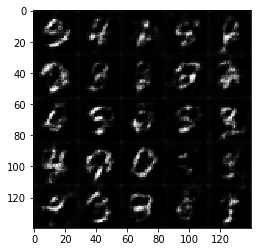

Epoch 1/2... Discriminator Loss: 1.5876... Generator Loss: 0.4410
Epoch 1/2... Discriminator Loss: 1.0691... Generator Loss: 0.9239
Epoch 1/2... Discriminator Loss: 1.4857... Generator Loss: 1.8409
Epoch 1/2... Discriminator Loss: 1.3018... Generator Loss: 0.6121
Epoch 1/2... Discriminator Loss: 1.1907... Generator Loss: 0.8499
Epoch 1/2... Discriminator Loss: 1.3304... Generator Loss: 1.3944
Epoch 1/2... Discriminator Loss: 1.5559... Generator Loss: 0.4718
Epoch 1/2... Discriminator Loss: 1.3137... Generator Loss: 1.1820
Epoch 1/2... Discriminator Loss: 1.5507... Generator Loss: 0.3952
Epoch 1/2... Discriminator Loss: 2.1141... Generator Loss: 0.2075


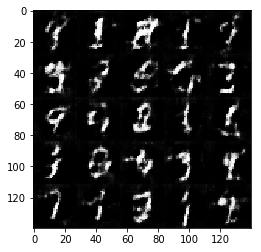

Epoch 1/2... Discriminator Loss: 1.4759... Generator Loss: 0.4552
Epoch 1/2... Discriminator Loss: 1.8248... Generator Loss: 0.3192
Epoch 1/2... Discriminator Loss: 1.5512... Generator Loss: 0.4021
Epoch 1/2... Discriminator Loss: 1.3118... Generator Loss: 0.5965
Epoch 1/2... Discriminator Loss: 1.2278... Generator Loss: 1.1423
Epoch 1/2... Discriminator Loss: 1.3303... Generator Loss: 0.7608
Epoch 1/2... Discriminator Loss: 1.3073... Generator Loss: 0.5519
Epoch 1/2... Discriminator Loss: 1.4144... Generator Loss: 0.5227
Epoch 1/2... Discriminator Loss: 1.2226... Generator Loss: 1.5738
Epoch 1/2... Discriminator Loss: 1.6040... Generator Loss: 0.3886


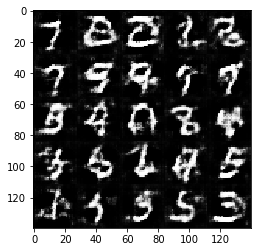

Epoch 1/2... Discriminator Loss: 1.6001... Generator Loss: 1.3346
Epoch 1/2... Discriminator Loss: 1.1031... Generator Loss: 1.0329
Epoch 1/2... Discriminator Loss: 1.1401... Generator Loss: 0.8687
Epoch 1/2... Discriminator Loss: 1.5213... Generator Loss: 1.1503
Epoch 1/2... Discriminator Loss: 1.3801... Generator Loss: 1.7242
Epoch 1/2... Discriminator Loss: 1.3825... Generator Loss: 1.5544
Epoch 1/2... Discriminator Loss: 1.3803... Generator Loss: 0.4970
Epoch 1/2... Discriminator Loss: 1.2338... Generator Loss: 1.1331
Epoch 1/2... Discriminator Loss: 1.5702... Generator Loss: 0.4191
Epoch 1/2... Discriminator Loss: 1.0939... Generator Loss: 0.8645


Epoch 1/2... Discriminator Loss: 1.4797... Generator Loss: 1.9647
Epoch 1/2... Discriminator Loss: 1.3086... Generator Loss: 1.5686
Epoch 1/2... Discriminator Loss: 1.0688... Generator Loss: 1.0067
Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 0.5095
Epoch 1/2... Discriminator Loss: 1.1982... Generator Loss: 0.7859
Epoch 1/2... Discriminator Loss: 1.1927... Generator Loss: 1.5555
Epoch 1/2... Discriminator Loss: 1.0678... Generator Loss: 0.9645
Epoch 1/2... Discriminator Loss: 1.9188... Generator Loss: 0.2885
Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 0.7230
Epoch 1/2... Discriminator Loss: 1.2586... Generator Loss: 0.8078


Epoch 1/2... Discriminator Loss: 1.1979... Generator Loss: 1.3544
Epoch 1/2... Discriminator Loss: 1.0471... Generator Loss: 1.3269
Epoch 1/2... Discriminator Loss: 1.2563... Generator Loss: 0.8187
Epoch 1/2... Discriminator Loss: 0.9957... Generator Loss: 1.1486
Epoch 1/2... Discriminator Loss: 1.4166... Generator Loss: 0.5255
Epoch 1/2... Discriminator Loss: 1.4440... Generator Loss: 2.0351
Epoch 1/2... Discriminator Loss: 1.3860... Generator Loss: 1.6298
Epoch 1/2... Discriminator Loss: 1.0636... Generator Loss: 0.9353
Epoch 1/2... Discriminator Loss: 1.0989... Generator Loss: 1.0757
Epoch 1/2... Discriminator Loss: 1.4828... Generator Loss: 2.3689


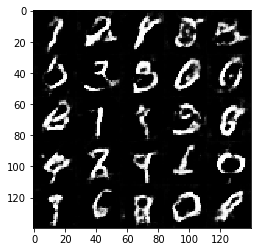

Epoch 1/2... Discriminator Loss: 1.1742... Generator Loss: 0.8254
Epoch 1/2... Discriminator Loss: 1.2481... Generator Loss: 0.6049
Epoch 1/2... Discriminator Loss: 1.3849... Generator Loss: 1.8750
Epoch 1/2... Discriminator Loss: 1.1329... Generator Loss: 0.9779
Epoch 1/2... Discriminator Loss: 2.1065... Generator Loss: 0.2632
Epoch 1/2... Discriminator Loss: 1.0490... Generator Loss: 1.1531
Epoch 1/2... Discriminator Loss: 0.8660... Generator Loss: 1.1206
Epoch 1/2... Discriminator Loss: 1.6739... Generator Loss: 0.3962
Epoch 1/2... Discriminator Loss: 1.2089... Generator Loss: 0.6686
Epoch 1/2... Discriminator Loss: 1.2262... Generator Loss: 0.9306


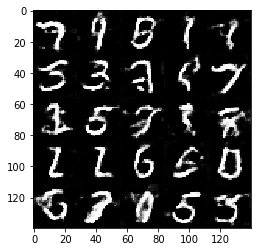

Epoch 1/2... Discriminator Loss: 0.9673... Generator Loss: 1.0296
Epoch 1/2... Discriminator Loss: 1.5876... Generator Loss: 0.4031
Epoch 1/2... Discriminator Loss: 1.7989... Generator Loss: 0.3131
Epoch 1/2... Discriminator Loss: 1.0669... Generator Loss: 0.8948
Epoch 1/2... Discriminator Loss: 1.0200... Generator Loss: 0.9622
Epoch 1/2... Discriminator Loss: 1.9002... Generator Loss: 0.3235
Epoch 1/2... Discriminator Loss: 1.8047... Generator Loss: 0.3329
Epoch 1/2... Discriminator Loss: 1.8483... Generator Loss: 0.2887
Epoch 1/2... Discriminator Loss: 0.9492... Generator Loss: 1.1556
Epoch 1/2... Discriminator Loss: 0.9812... Generator Loss: 0.9251


Epoch 1/2... Discriminator Loss: 0.9530... Generator Loss: 1.0573
Epoch 1/2... Discriminator Loss: 1.1974... Generator Loss: 0.7085
Epoch 1/2... Discriminator Loss: 1.1134... Generator Loss: 0.9257
Epoch 1/2... Discriminator Loss: 1.1619... Generator Loss: 0.9522
Epoch 1/2... Discriminator Loss: 1.0011... Generator Loss: 0.8549
Epoch 1/2... Discriminator Loss: 1.9664... Generator Loss: 0.2683
Epoch 1/2... Discriminator Loss: 0.9712... Generator Loss: 1.1505
Epoch 1/2... Discriminator Loss: 1.4318... Generator Loss: 2.6975
Epoch 1/2... Discriminator Loss: 1.1756... Generator Loss: 1.2294
Epoch 1/2... Discriminator Loss: 1.1735... Generator Loss: 0.7090


Epoch 1/2... Discriminator Loss: 0.9967... Generator Loss: 0.8879
Epoch 1/2... Discriminator Loss: 1.4422... Generator Loss: 0.5286
Epoch 1/2... Discriminator Loss: 1.1836... Generator Loss: 0.7126
Epoch 1/2... Discriminator Loss: 1.2378... Generator Loss: 0.6503
Epoch 1/2... Discriminator Loss: 1.2122... Generator Loss: 0.6696
Epoch 1/2... Discriminator Loss: 1.1744... Generator Loss: 1.7742
Epoch 1/2... Discriminator Loss: 1.7184... Generator Loss: 0.3848
Epoch 1/2... Discriminator Loss: 1.3294... Generator Loss: 0.5822
Epoch 1/2... Discriminator Loss: 0.9206... Generator Loss: 0.9857
Epoch 1/2... Discriminator Loss: 0.9008... Generator Loss: 1.3611


Epoch 1/2... Discriminator Loss: 1.1699... Generator Loss: 0.6567
Epoch 1/2... Discriminator Loss: 1.3921... Generator Loss: 1.2948
Epoch 1/2... Discriminator Loss: 1.0632... Generator Loss: 1.0124
Epoch 1/2... Discriminator Loss: 1.6628... Generator Loss: 0.4007
Epoch 1/2... Discriminator Loss: 1.0808... Generator Loss: 1.1729
Epoch 1/2... Discriminator Loss: 1.0052... Generator Loss: 0.9572
Epoch 1/2... Discriminator Loss: 1.3890... Generator Loss: 0.6020
Epoch 1/2... Discriminator Loss: 1.6540... Generator Loss: 0.3820
Epoch 1/2... Discriminator Loss: 0.8174... Generator Loss: 1.4825
Epoch 1/2... Discriminator Loss: 1.9047... Generator Loss: 3.2025


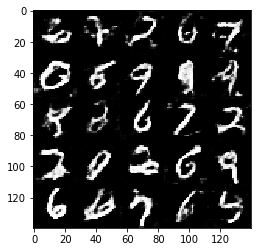

Epoch 1/2... Discriminator Loss: 1.0267... Generator Loss: 0.8995
Epoch 1/2... Discriminator Loss: 0.9553... Generator Loss: 1.0664
Epoch 1/2... Discriminator Loss: 0.8034... Generator Loss: 1.1572
Epoch 1/2... Discriminator Loss: 1.4793... Generator Loss: 0.4915
Epoch 1/2... Discriminator Loss: 0.7764... Generator Loss: 1.4428
Epoch 1/2... Discriminator Loss: 1.5226... Generator Loss: 0.5392
Epoch 1/2... Discriminator Loss: 0.9824... Generator Loss: 0.8882
Epoch 1/2... Discriminator Loss: 1.4232... Generator Loss: 0.5203
Epoch 1/2... Discriminator Loss: 0.8968... Generator Loss: 1.2370
Epoch 1/2... Discriminator Loss: 0.7834... Generator Loss: 1.5462


Epoch 1/2... Discriminator Loss: 0.9719... Generator Loss: 1.2214
Epoch 1/2... Discriminator Loss: 1.3569... Generator Loss: 0.5469
Epoch 1/2... Discriminator Loss: 1.3511... Generator Loss: 0.5687
Epoch 1/2... Discriminator Loss: 1.2216... Generator Loss: 0.7019
Epoch 1/2... Discriminator Loss: 1.6291... Generator Loss: 0.4484
Epoch 1/2... Discriminator Loss: 0.9477... Generator Loss: 1.2846
Epoch 1/2... Discriminator Loss: 0.9896... Generator Loss: 0.9518
Epoch 1/2... Discriminator Loss: 1.0162... Generator Loss: 0.8476
Epoch 1/2... Discriminator Loss: 0.7130... Generator Loss: 1.5069
Epoch 1/2... Discriminator Loss: 1.2757... Generator Loss: 0.6205


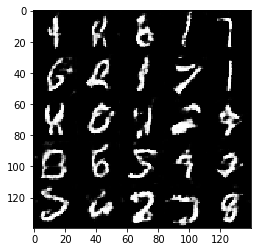

Epoch 1/2... Discriminator Loss: 0.7673... Generator Loss: 1.6438
Epoch 1/2... Discriminator Loss: 2.6456... Generator Loss: 0.1988
Epoch 1/2... Discriminator Loss: 1.0331... Generator Loss: 2.4552
Epoch 1/2... Discriminator Loss: 0.9970... Generator Loss: 1.1287
Epoch 1/2... Discriminator Loss: 0.7815... Generator Loss: 1.2273
Epoch 1/2... Discriminator Loss: 1.1403... Generator Loss: 2.0462
Epoch 1/2... Discriminator Loss: 2.7774... Generator Loss: 0.1574
Epoch 1/2... Discriminator Loss: 1.0657... Generator Loss: 1.3386
Epoch 1/2... Discriminator Loss: 1.8266... Generator Loss: 2.0420
Epoch 1/2... Discriminator Loss: 1.0516... Generator Loss: 1.5707


Epoch 1/2... Discriminator Loss: 2.3546... Generator Loss: 0.2081
Epoch 1/2... Discriminator Loss: 1.2160... Generator Loss: 0.7301
Epoch 1/2... Discriminator Loss: 1.8165... Generator Loss: 0.4280
Epoch 1/2... Discriminator Loss: 0.9177... Generator Loss: 1.0436
Epoch 1/2... Discriminator Loss: 1.1061... Generator Loss: 0.7591
Epoch 1/2... Discriminator Loss: 1.1844... Generator Loss: 2.2266
Epoch 1/2... Discriminator Loss: 0.9238... Generator Loss: 2.1401
Epoch 1/2... Discriminator Loss: 1.6965... Generator Loss: 0.4495
Epoch 1/2... Discriminator Loss: 1.4634... Generator Loss: 0.5189
Epoch 1/2... Discriminator Loss: 0.9416... Generator Loss: 0.9816


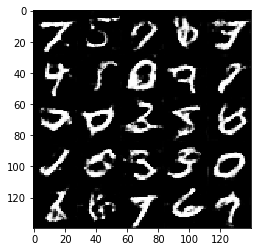

Epoch 1/2... Discriminator Loss: 1.3812... Generator Loss: 0.5733
Epoch 1/2... Discriminator Loss: 1.2868... Generator Loss: 0.6252
Epoch 1/2... Discriminator Loss: 0.8687... Generator Loss: 1.0213
Epoch 1/2... Discriminator Loss: 1.3461... Generator Loss: 0.6295
Epoch 1/2... Discriminator Loss: 0.8312... Generator Loss: 1.1188
Epoch 1/2... Discriminator Loss: 0.5274... Generator Loss: 2.2199
Epoch 1/2... Discriminator Loss: 0.9498... Generator Loss: 1.6586
Epoch 1/2... Discriminator Loss: 0.6631... Generator Loss: 1.5838
Epoch 1/2... Discriminator Loss: 0.7545... Generator Loss: 1.7562
Epoch 1/2... Discriminator Loss: 0.6673... Generator Loss: 1.8573


Epoch 1/2... Discriminator Loss: 0.7772... Generator Loss: 1.3341
Epoch 1/2... Discriminator Loss: 1.5971... Generator Loss: 0.6847
Epoch 1/2... Discriminator Loss: 1.0925... Generator Loss: 2.2426
Epoch 1/2... Discriminator Loss: 1.0716... Generator Loss: 1.5515
Epoch 1/2... Discriminator Loss: 0.8019... Generator Loss: 1.4118
Epoch 1/2... Discriminator Loss: 1.4537... Generator Loss: 0.4986
Epoch 1/2... Discriminator Loss: 1.0161... Generator Loss: 1.5011
Epoch 1/2... Discriminator Loss: 1.0124... Generator Loss: 2.6415
Epoch 1/2... Discriminator Loss: 0.8396... Generator Loss: 1.6740
Epoch 1/2... Discriminator Loss: 0.6328... Generator Loss: 1.8012


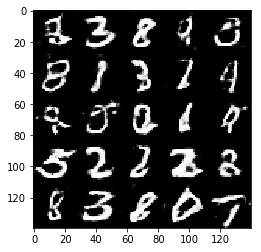

Epoch 1/2... Discriminator Loss: 1.2710... Generator Loss: 2.5770
Epoch 1/2... Discriminator Loss: 0.9125... Generator Loss: 1.0467
Epoch 1/2... Discriminator Loss: 1.0518... Generator Loss: 0.8019
Epoch 1/2... Discriminator Loss: 0.8128... Generator Loss: 1.7179
Epoch 1/2... Discriminator Loss: 1.7191... Generator Loss: 0.4629
Epoch 1/2... Discriminator Loss: 1.6506... Generator Loss: 0.4033
Epoch 1/2... Discriminator Loss: 0.8778... Generator Loss: 1.0499
Epoch 2/2... Discriminator Loss: 0.6760... Generator Loss: 2.1572
Epoch 2/2... Discriminator Loss: 0.8096... Generator Loss: 1.5896
Epoch 2/2... Discriminator Loss: 0.6811... Generator Loss: 1.8192


Epoch 2/2... Discriminator Loss: 1.5397... Generator Loss: 0.4413
Epoch 2/2... Discriminator Loss: 0.8682... Generator Loss: 1.4004
Epoch 2/2... Discriminator Loss: 1.3722... Generator Loss: 0.6049
Epoch 2/2... Discriminator Loss: 0.8514... Generator Loss: 2.4971
Epoch 2/2... Discriminator Loss: 1.4358... Generator Loss: 0.6069
Epoch 2/2... Discriminator Loss: 0.7535... Generator Loss: 1.3132
Epoch 2/2... Discriminator Loss: 1.8603... Generator Loss: 0.3484
Epoch 2/2... Discriminator Loss: 0.9267... Generator Loss: 1.0553
Epoch 2/2... Discriminator Loss: 0.6695... Generator Loss: 1.5139
Epoch 2/2... Discriminator Loss: 0.8175... Generator Loss: 2.3693


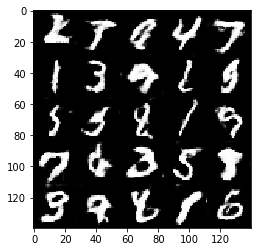

Epoch 2/2... Discriminator Loss: 0.5348... Generator Loss: 2.1660
Epoch 2/2... Discriminator Loss: 0.5969... Generator Loss: 1.9024
Epoch 2/2... Discriminator Loss: 1.2606... Generator Loss: 0.7054
Epoch 2/2... Discriminator Loss: 0.6276... Generator Loss: 1.6209
Epoch 2/2... Discriminator Loss: 0.8920... Generator Loss: 1.0347
Epoch 2/2... Discriminator Loss: 0.5389... Generator Loss: 2.0046
Epoch 2/2... Discriminator Loss: 0.8452... Generator Loss: 1.1457
Epoch 2/2... Discriminator Loss: 1.1705... Generator Loss: 0.7316
Epoch 2/2... Discriminator Loss: 1.1636... Generator Loss: 0.8011
Epoch 2/2... Discriminator Loss: 0.8891... Generator Loss: 1.1182


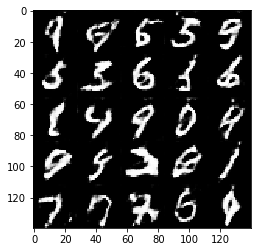

Epoch 2/2... Discriminator Loss: 1.5489... Generator Loss: 0.5626
Epoch 2/2... Discriminator Loss: 0.6290... Generator Loss: 1.6802
Epoch 2/2... Discriminator Loss: 0.6259... Generator Loss: 1.6587
Epoch 2/2... Discriminator Loss: 1.0224... Generator Loss: 3.5063
Epoch 2/2... Discriminator Loss: 0.7901... Generator Loss: 1.5688
Epoch 2/2... Discriminator Loss: 0.9485... Generator Loss: 1.4065
Epoch 2/2... Discriminator Loss: 0.7849... Generator Loss: 1.2586
Epoch 2/2... Discriminator Loss: 0.6410... Generator Loss: 1.6475
Epoch 2/2... Discriminator Loss: 0.5130... Generator Loss: 2.1601
Epoch 2/2... Discriminator Loss: 0.6399... Generator Loss: 1.5785


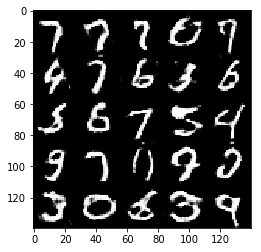

Epoch 2/2... Discriminator Loss: 6.1450... Generator Loss: 0.0372
Epoch 2/2... Discriminator Loss: 0.8472... Generator Loss: 1.9397
Epoch 2/2... Discriminator Loss: 1.1469... Generator Loss: 0.6935
Epoch 2/2... Discriminator Loss: 1.0161... Generator Loss: 0.9240
Epoch 2/2... Discriminator Loss: 1.1429... Generator Loss: 0.8505
Epoch 2/2... Discriminator Loss: 0.8237... Generator Loss: 1.7164
Epoch 2/2... Discriminator Loss: 0.8628... Generator Loss: 1.2252
Epoch 2/2... Discriminator Loss: 0.6149... Generator Loss: 1.6161
Epoch 2/2... Discriminator Loss: 0.6015... Generator Loss: 2.1671
Epoch 2/2... Discriminator Loss: 0.6028... Generator Loss: 2.1707


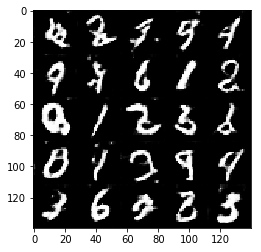

Epoch 2/2... Discriminator Loss: 0.7727... Generator Loss: 2.2079
Epoch 2/2... Discriminator Loss: 1.1001... Generator Loss: 0.7292
Epoch 2/2... Discriminator Loss: 0.8192... Generator Loss: 1.1719
Epoch 2/2... Discriminator Loss: 1.1867... Generator Loss: 2.2797
Epoch 2/2... Discriminator Loss: 0.5689... Generator Loss: 1.8252
Epoch 2/2... Discriminator Loss: 0.6422... Generator Loss: 1.7638
Epoch 2/2... Discriminator Loss: 0.6061... Generator Loss: 1.8815
Epoch 2/2... Discriminator Loss: 1.5055... Generator Loss: 0.6551
Epoch 2/2... Discriminator Loss: 1.2521... Generator Loss: 0.7395
Epoch 2/2... Discriminator Loss: 0.9915... Generator Loss: 0.8209


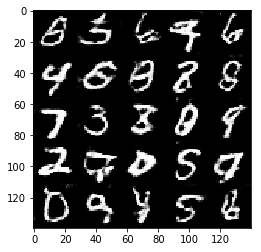

Epoch 2/2... Discriminator Loss: 0.6653... Generator Loss: 1.4305
Epoch 2/2... Discriminator Loss: 0.6419... Generator Loss: 1.8357
Epoch 2/2... Discriminator Loss: 0.6407... Generator Loss: 1.6804
Epoch 2/2... Discriminator Loss: 0.8393... Generator Loss: 1.2280
Epoch 2/2... Discriminator Loss: 0.7510... Generator Loss: 1.5975
Epoch 2/2... Discriminator Loss: 0.7434... Generator Loss: 1.3320
Epoch 2/2... Discriminator Loss: 2.2815... Generator Loss: 0.3055
Epoch 2/2... Discriminator Loss: 0.8488... Generator Loss: 1.1544
Epoch 2/2... Discriminator Loss: 0.9927... Generator Loss: 0.9195
Epoch 2/2... Discriminator Loss: 0.8989... Generator Loss: 2.6111


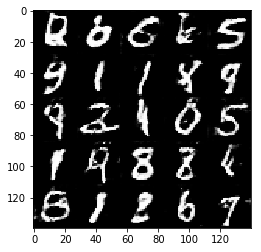

Epoch 2/2... Discriminator Loss: 1.0552... Generator Loss: 2.5978
Epoch 2/2... Discriminator Loss: 0.6769... Generator Loss: 1.6761
Epoch 2/2... Discriminator Loss: 1.5316... Generator Loss: 0.5102
Epoch 2/2... Discriminator Loss: 1.0474... Generator Loss: 0.9783
Epoch 2/2... Discriminator Loss: 0.8405... Generator Loss: 1.2260
Epoch 2/2... Discriminator Loss: 1.8106... Generator Loss: 0.4197
Epoch 2/2... Discriminator Loss: 0.6568... Generator Loss: 1.6755
Epoch 2/2... Discriminator Loss: 0.7446... Generator Loss: 1.3011
Epoch 2/2... Discriminator Loss: 0.7786... Generator Loss: 1.3027
Epoch 2/2... Discriminator Loss: 0.4917... Generator Loss: 2.2849


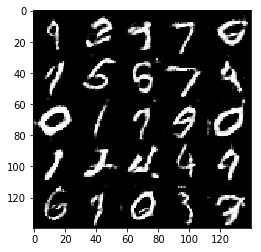

Epoch 2/2... Discriminator Loss: 0.9170... Generator Loss: 1.1458
Epoch 2/2... Discriminator Loss: 0.5964... Generator Loss: 1.7446
Epoch 2/2... Discriminator Loss: 1.6960... Generator Loss: 0.4844
Epoch 2/2... Discriminator Loss: 1.3705... Generator Loss: 0.7913
Epoch 2/2... Discriminator Loss: 1.6971... Generator Loss: 4.0855
Epoch 2/2... Discriminator Loss: 0.7893... Generator Loss: 1.5801
Epoch 2/2... Discriminator Loss: 0.9937... Generator Loss: 0.9208
Epoch 2/2... Discriminator Loss: 0.5551... Generator Loss: 2.6961
Epoch 2/2... Discriminator Loss: 0.6110... Generator Loss: 1.6866
Epoch 2/2... Discriminator Loss: 0.7240... Generator Loss: 1.4152


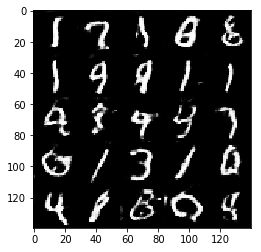

Epoch 2/2... Discriminator Loss: 0.6035... Generator Loss: 2.1967
Epoch 2/2... Discriminator Loss: 1.0665... Generator Loss: 0.8909
Epoch 2/2... Discriminator Loss: 2.0666... Generator Loss: 0.3337
Epoch 2/2... Discriminator Loss: 1.1476... Generator Loss: 1.0411
Epoch 2/2... Discriminator Loss: 1.4065... Generator Loss: 0.7581
Epoch 2/2... Discriminator Loss: 1.9059... Generator Loss: 0.3771
Epoch 2/2... Discriminator Loss: 0.8125... Generator Loss: 1.1795
Epoch 2/2... Discriminator Loss: 0.6956... Generator Loss: 1.6054
Epoch 2/2... Discriminator Loss: 0.7040... Generator Loss: 1.3691
Epoch 2/2... Discriminator Loss: 0.7339... Generator Loss: 1.3044


Epoch 2/2... Discriminator Loss: 1.2329... Generator Loss: 3.6960
Epoch 2/2... Discriminator Loss: 0.8514... Generator Loss: 1.1100
Epoch 2/2... Discriminator Loss: 0.6454... Generator Loss: 2.1886
Epoch 2/2... Discriminator Loss: 0.9892... Generator Loss: 0.8956
Epoch 2/2... Discriminator Loss: 1.0035... Generator Loss: 0.8726
Epoch 2/2... Discriminator Loss: 0.9713... Generator Loss: 0.8801
Epoch 2/2... Discriminator Loss: 0.8378... Generator Loss: 1.3902
Epoch 2/2... Discriminator Loss: 0.5570... Generator Loss: 1.9692
Epoch 2/2... Discriminator Loss: 0.6374... Generator Loss: 1.8028
Epoch 2/2... Discriminator Loss: 3.3226... Generator Loss: 6.0729


Epoch 2/2... Discriminator Loss: 0.7109... Generator Loss: 1.4064
Epoch 2/2... Discriminator Loss: 1.0389... Generator Loss: 0.8967
Epoch 2/2... Discriminator Loss: 0.6478... Generator Loss: 1.6727
Epoch 2/2... Discriminator Loss: 0.7368... Generator Loss: 1.2840
Epoch 2/2... Discriminator Loss: 0.7155... Generator Loss: 1.4864
Epoch 2/2... Discriminator Loss: 0.6561... Generator Loss: 1.4897
Epoch 2/2... Discriminator Loss: 0.7074... Generator Loss: 1.4142
Epoch 2/2... Discriminator Loss: 0.7522... Generator Loss: 1.4022
Epoch 2/2... Discriminator Loss: 0.6319... Generator Loss: 1.7521
Epoch 2/2... Discriminator Loss: 1.5344... Generator Loss: 4.5296


Epoch 2/2... Discriminator Loss: 0.6334... Generator Loss: 1.9199
Epoch 2/2... Discriminator Loss: 0.7682... Generator Loss: 1.3941
Epoch 2/2... Discriminator Loss: 0.6610... Generator Loss: 1.4774
Epoch 2/2... Discriminator Loss: 0.7760... Generator Loss: 1.2870
Epoch 2/2... Discriminator Loss: 0.6674... Generator Loss: 1.4825
Epoch 2/2... Discriminator Loss: 0.8802... Generator Loss: 1.0558
Epoch 2/2... Discriminator Loss: 0.5549... Generator Loss: 2.0320
Epoch 2/2... Discriminator Loss: 0.7808... Generator Loss: 1.2173
Epoch 2/2... Discriminator Loss: 3.1546... Generator Loss: 0.1262
Epoch 2/2... Discriminator Loss: 0.7849... Generator Loss: 1.4395


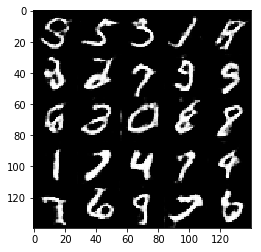

Epoch 2/2... Discriminator Loss: 0.5510... Generator Loss: 2.5927
Epoch 2/2... Discriminator Loss: 1.0475... Generator Loss: 1.0526
Epoch 2/2... Discriminator Loss: 0.6633... Generator Loss: 1.5291
Epoch 2/2... Discriminator Loss: 0.8733... Generator Loss: 1.1520
Epoch 2/2... Discriminator Loss: 0.6860... Generator Loss: 1.4330
Epoch 2/2... Discriminator Loss: 0.5799... Generator Loss: 1.8091
Epoch 2/2... Discriminator Loss: 0.8468... Generator Loss: 1.2015
Epoch 2/2... Discriminator Loss: 0.7652... Generator Loss: 1.1756
Epoch 2/2... Discriminator Loss: 0.8996... Generator Loss: 1.1011
Epoch 2/2... Discriminator Loss: 1.0430... Generator Loss: 0.9712


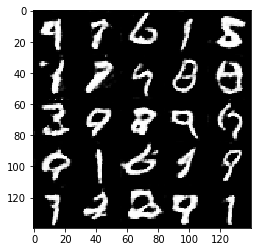

Epoch 2/2... Discriminator Loss: 0.6947... Generator Loss: 1.8376
Epoch 2/2... Discriminator Loss: 1.6657... Generator Loss: 0.4074
Epoch 2/2... Discriminator Loss: 1.0723... Generator Loss: 0.9007
Epoch 2/2... Discriminator Loss: 0.9625... Generator Loss: 1.3122
Epoch 2/2... Discriminator Loss: 0.4727... Generator Loss: 2.4675
Epoch 2/2... Discriminator Loss: 0.8410... Generator Loss: 1.1666
Epoch 2/2... Discriminator Loss: 0.8480... Generator Loss: 1.1923
Epoch 2/2... Discriminator Loss: 0.6419... Generator Loss: 1.9470
Epoch 2/2... Discriminator Loss: 0.8433... Generator Loss: 1.1488
Epoch 2/2... Discriminator Loss: 0.8316... Generator Loss: 1.3406


Epoch 2/2... Discriminator Loss: 0.6021... Generator Loss: 1.8103
Epoch 2/2... Discriminator Loss: 0.4890... Generator Loss: 2.5509
Epoch 2/2... Discriminator Loss: 0.5135... Generator Loss: 2.6246
Epoch 2/2... Discriminator Loss: 0.8798... Generator Loss: 2.8250
Epoch 2/2... Discriminator Loss: 0.7910... Generator Loss: 3.2306
Epoch 2/2... Discriminator Loss: 0.5034... Generator Loss: 2.3904
Epoch 2/2... Discriminator Loss: 0.9455... Generator Loss: 0.9764
Epoch 2/2... Discriminator Loss: 0.8999... Generator Loss: 1.0572
Epoch 2/2... Discriminator Loss: 5.3045... Generator Loss: 0.0429
Epoch 2/2... Discriminator Loss: 1.3494... Generator Loss: 0.6220


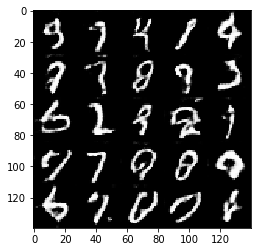

Epoch 2/2... Discriminator Loss: 2.0060... Generator Loss: 0.3538
Epoch 2/2... Discriminator Loss: 0.7518... Generator Loss: 1.4173
Epoch 2/2... Discriminator Loss: 1.5082... Generator Loss: 0.4293
Epoch 2/2... Discriminator Loss: 0.8065... Generator Loss: 1.2228
Epoch 2/2... Discriminator Loss: 0.8828... Generator Loss: 1.0545
Epoch 2/2... Discriminator Loss: 1.7642... Generator Loss: 4.4798
Epoch 2/2... Discriminator Loss: 0.6275... Generator Loss: 1.6340
Epoch 2/2... Discriminator Loss: 0.6418... Generator Loss: 1.5931
Epoch 2/2... Discriminator Loss: 0.6299... Generator Loss: 1.9135
Epoch 2/2... Discriminator Loss: 0.5846... Generator Loss: 1.8212


Epoch 2/2... Discriminator Loss: 0.7754... Generator Loss: 1.3400
Epoch 2/2... Discriminator Loss: 0.9788... Generator Loss: 1.0357
Epoch 2/2... Discriminator Loss: 0.6153... Generator Loss: 1.6752
Epoch 2/2... Discriminator Loss: 1.7454... Generator Loss: 0.5164
Epoch 2/2... Discriminator Loss: 0.6143... Generator Loss: 1.7423
Epoch 2/2... Discriminator Loss: 0.6285... Generator Loss: 1.6494
Epoch 2/2... Discriminator Loss: 1.4181... Generator Loss: 0.7341
Epoch 2/2... Discriminator Loss: 0.6948... Generator Loss: 1.6129
Epoch 2/2... Discriminator Loss: 3.4054... Generator Loss: 5.0255
Epoch 2/2... Discriminator Loss: 0.8488... Generator Loss: 1.1441


Epoch 2/2... Discriminator Loss: 0.4529... Generator Loss: 2.6153
Epoch 2/2... Discriminator Loss: 0.7826... Generator Loss: 1.7795
Epoch 2/2... Discriminator Loss: 0.5511... Generator Loss: 2.1576
Epoch 2/2... Discriminator Loss: 0.9823... Generator Loss: 0.9576
Epoch 2/2... Discriminator Loss: 0.7472... Generator Loss: 1.4179
Epoch 2/2... Discriminator Loss: 0.7480... Generator Loss: 1.3375
Epoch 2/2... Discriminator Loss: 0.6767... Generator Loss: 1.6390
Epoch 2/2... Discriminator Loss: 0.8965... Generator Loss: 0.9928
Epoch 2/2... Discriminator Loss: 0.5515... Generator Loss: 2.1958
Epoch 2/2... Discriminator Loss: 1.0398... Generator Loss: 2.9194


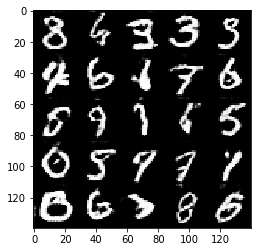

Epoch 2/2... Discriminator Loss: 0.6268... Generator Loss: 3.3544
Epoch 2/2... Discriminator Loss: 0.6168... Generator Loss: 1.8589
Epoch 2/2... Discriminator Loss: 0.9348... Generator Loss: 0.9852
Epoch 2/2... Discriminator Loss: 2.4095... Generator Loss: 0.2394
Epoch 2/2... Discriminator Loss: 0.5750... Generator Loss: 1.9700


In [12]:
batch_size = 32
z_dim = 64
learning_rate = 1e-3
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5102... Generator Loss: 11.7671
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 1.7993
Epoch 1/1... Discriminator Loss: 2.1504... Generator Loss: 2.8514
Epoch 1/1... Discriminator Loss: 1.7973... Generator Loss: 0.3975
Epoch 1/1... Discriminator Loss: 2.2140... Generator Loss: 2.7785
Epoch 1/1... Discriminator Loss: 2.0288... Generator Loss: 2.1227
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 0.9835
Epoch 1/1... Discriminator Loss: 1.5959... Generator Loss: 0.4690
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 1.0025
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.9610


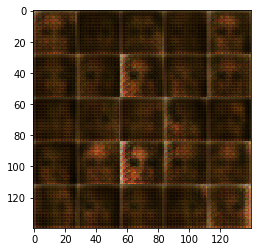

Epoch 1/1... Discriminator Loss: 2.2259... Generator Loss: 0.1881
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 0.8043... Generator Loss: 1.1736
Epoch 1/1... Discriminator Loss: 1.6466... Generator Loss: 0.5041
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 0.8477... Generator Loss: 2.1747
Epoch 1/1... Discriminator Loss: 1.6046... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.6102


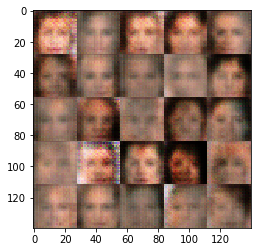

Epoch 1/1... Discriminator Loss: 0.7495... Generator Loss: 3.0286
Epoch 1/1... Discriminator Loss: 3.4615... Generator Loss: 3.2020
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.7329


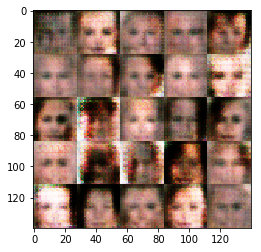

Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.5304... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.9747
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 1.7479


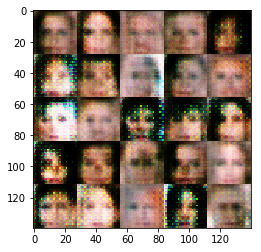

Epoch 1/1... Discriminator Loss: 0.7297... Generator Loss: 2.2935
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 1.9624
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 2.0945... Generator Loss: 0.2092
Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 2.1887
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 1.6599
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 2.4349
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 1.3980
Epoch 1/1... Discriminator Loss: 0.6175... Generator Loss: 2.1189
Epoch 1/1... Discriminator Loss: 2.0329... Generator Loss: 1.7951


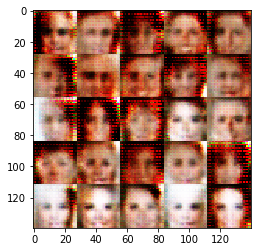

Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 1.6030
Epoch 1/1... Discriminator Loss: 0.8611... Generator Loss: 1.7435
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.6109
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.4996
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 0.5111... Generator Loss: 2.5577


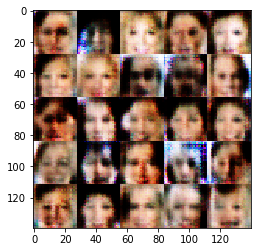

Epoch 1/1... Discriminator Loss: 0.7832... Generator Loss: 3.5691
Epoch 1/1... Discriminator Loss: 0.6086... Generator Loss: 1.5425
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 0.6464... Generator Loss: 3.0224
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 1.8699
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 1.0124
Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.6196... Generator Loss: 0.3962
Epoch 1/1... Discriminator Loss: 0.4507... Generator Loss: 2.4981
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 0.9661


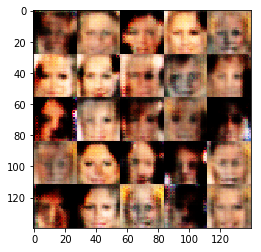

Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 0.5415... Generator Loss: 1.7402
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 0.6814... Generator Loss: 1.8567
Epoch 1/1... Discriminator Loss: 0.6561... Generator Loss: 3.0073
Epoch 1/1... Discriminator Loss: 0.4004... Generator Loss: 2.8531
Epoch 1/1... Discriminator Loss: 0.4191... Generator Loss: 2.8637
Epoch 1/1... Discriminator Loss: 0.3496... Generator Loss: 4.7906
Epoch 1/1... Discriminator Loss: 0.3911... Generator Loss: 5.4610
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 1.9253


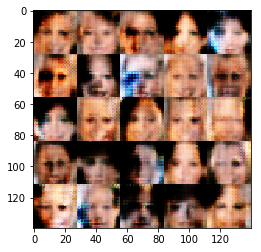

Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 1.4633
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.4113
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 2.5339
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 1.6616
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 0.8353... Generator Loss: 1.4244
Epoch 1/1... Discriminator Loss: 2.3538... Generator Loss: 0.1730
Epoch 1/1... Discriminator Loss: 0.8270... Generator Loss: 1.1832


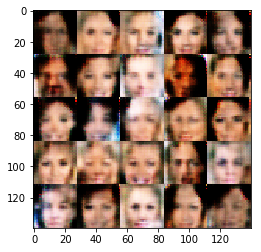

Epoch 1/1... Discriminator Loss: 0.9502... Generator Loss: 1.3899
Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 1.5322
Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 2.2805
Epoch 1/1... Discriminator Loss: 0.7748... Generator Loss: 3.3212
Epoch 1/1... Discriminator Loss: 0.7865... Generator Loss: 1.0695
Epoch 1/1... Discriminator Loss: 0.9702... Generator Loss: 1.3970
Epoch 1/1... Discriminator Loss: 0.5481... Generator Loss: 1.8610
Epoch 1/1... Discriminator Loss: 0.6502... Generator Loss: 3.1250
Epoch 1/1... Discriminator Loss: 0.4600... Generator Loss: 2.3822
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 1.3937


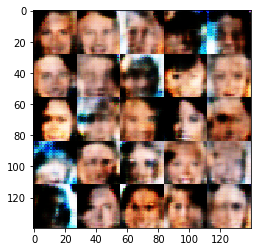

Epoch 1/1... Discriminator Loss: 0.5732... Generator Loss: 1.7563
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.0355
Epoch 1/1... Discriminator Loss: 0.4662... Generator Loss: 2.4761
Epoch 1/1... Discriminator Loss: 0.4080... Generator Loss: 3.3566
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 0.4014... Generator Loss: 3.4349
Epoch 1/1... Discriminator Loss: 0.6124... Generator Loss: 1.9768
Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 1.2250
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 2.4497
Epoch 1/1... Discriminator Loss: 0.4910... Generator Loss: 2.1259


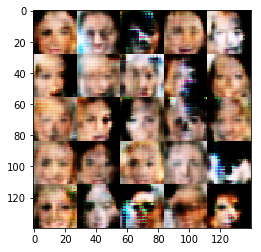

Epoch 1/1... Discriminator Loss: 0.6443... Generator Loss: 1.6698
Epoch 1/1... Discriminator Loss: 0.4162... Generator Loss: 4.1886
Epoch 1/1... Discriminator Loss: 0.4610... Generator Loss: 2.3261
Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 1.5378
Epoch 1/1... Discriminator Loss: 0.9173... Generator Loss: 1.4283
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 0.8286... Generator Loss: 1.4303
Epoch 1/1... Discriminator Loss: 0.4337... Generator Loss: 2.5677
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 0.6566... Generator Loss: 1.4915


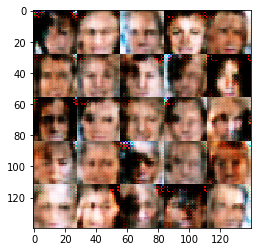

Epoch 1/1... Discriminator Loss: 0.5605... Generator Loss: 1.8834
Epoch 1/1... Discriminator Loss: 0.5805... Generator Loss: 2.1850
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 2.5147
Epoch 1/1... Discriminator Loss: 0.6775... Generator Loss: 1.5085
Epoch 1/1... Discriminator Loss: 0.4872... Generator Loss: 2.8825
Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 0.5095
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 3.1014
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 0.6909... Generator Loss: 1.3611


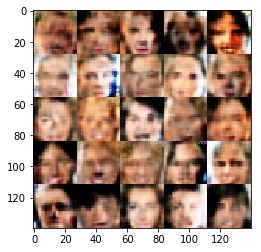

Epoch 1/1... Discriminator Loss: 0.5816... Generator Loss: 1.7626
Epoch 1/1... Discriminator Loss: 2.6080... Generator Loss: 2.9917
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 2.9480
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 1.5338
Epoch 1/1... Discriminator Loss: 0.4039... Generator Loss: 4.1564
Epoch 1/1... Discriminator Loss: 1.8730... Generator Loss: 1.5096
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 1.0656
Epoch 1/1... Discriminator Loss: 0.4972... Generator Loss: 2.2673
Epoch 1/1... Discriminator Loss: 0.5584... Generator Loss: 2.5081


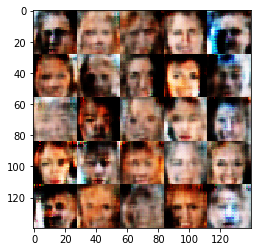

Epoch 1/1... Discriminator Loss: 0.5126... Generator Loss: 2.7265
Epoch 1/1... Discriminator Loss: 0.5040... Generator Loss: 2.5634
Epoch 1/1... Discriminator Loss: 0.4043... Generator Loss: 3.2055
Epoch 1/1... Discriminator Loss: 1.6391... Generator Loss: 3.0308
Epoch 1/1... Discriminator Loss: 0.6707... Generator Loss: 1.5625
Epoch 1/1... Discriminator Loss: 0.4154... Generator Loss: 2.9118
Epoch 1/1... Discriminator Loss: 0.5088... Generator Loss: 2.2754
Epoch 1/1... Discriminator Loss: 0.4925... Generator Loss: 2.3232
Epoch 1/1... Discriminator Loss: 0.4483... Generator Loss: 2.5089
Epoch 1/1... Discriminator Loss: 0.4131... Generator Loss: 2.9901


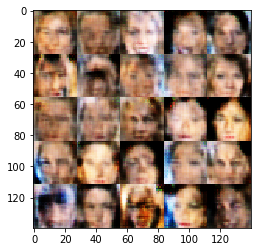

Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 1.8502
Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 1.1570
Epoch 1/1... Discriminator Loss: 3.1606... Generator Loss: 0.0742
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 1.1143
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 1.1714
Epoch 1/1... Discriminator Loss: 0.8734... Generator Loss: 1.6772
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 1.2532
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.5019
Epoch 1/1... Discriminator Loss: 0.4672... Generator Loss: 3.3077
Epoch 1/1... Discriminator Loss: 0.5219... Generator Loss: 2.3284


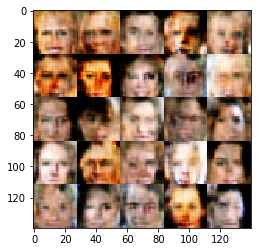

Epoch 1/1... Discriminator Loss: 0.6267... Generator Loss: 2.1761
Epoch 1/1... Discriminator Loss: 3.1620... Generator Loss: 4.5108
Epoch 1/1... Discriminator Loss: 0.4495... Generator Loss: 2.7134
Epoch 1/1... Discriminator Loss: 0.4660... Generator Loss: 2.9447
Epoch 1/1... Discriminator Loss: 0.4290... Generator Loss: 2.6696
Epoch 1/1... Discriminator Loss: 2.4038... Generator Loss: 2.1499
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 0.4484... Generator Loss: 2.6011
Epoch 1/1... Discriminator Loss: 2.4950... Generator Loss: 0.2006


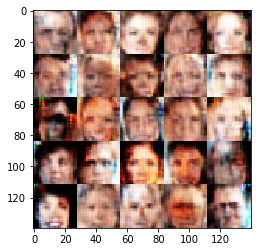

Epoch 1/1... Discriminator Loss: 0.7808... Generator Loss: 1.2273
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 1.5613
Epoch 1/1... Discriminator Loss: 0.4387... Generator Loss: 2.6772
Epoch 1/1... Discriminator Loss: 1.6863... Generator Loss: 0.4154
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 1.2203
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 1.2434
Epoch 1/1... Discriminator Loss: 0.6221... Generator Loss: 3.0555
Epoch 1/1... Discriminator Loss: 0.3931... Generator Loss: 3.9757
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 1.3007
Epoch 1/1... Discriminator Loss: 0.7145... Generator Loss: 1.3267


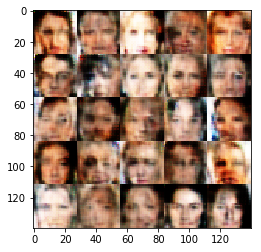

Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 1.8047
Epoch 1/1... Discriminator Loss: 0.4154... Generator Loss: 3.2976
Epoch 1/1... Discriminator Loss: 0.5210... Generator Loss: 1.9938
Epoch 1/1... Discriminator Loss: 0.3984... Generator Loss: 3.3225
Epoch 1/1... Discriminator Loss: 0.6362... Generator Loss: 2.3960
Epoch 1/1... Discriminator Loss: 0.3635... Generator Loss: 3.9705
Epoch 1/1... Discriminator Loss: 0.4352... Generator Loss: 3.5357
Epoch 1/1... Discriminator Loss: 3.1378... Generator Loss: 4.1253
Epoch 1/1... Discriminator Loss: 0.4631... Generator Loss: 2.3807
Epoch 1/1... Discriminator Loss: 0.7732... Generator Loss: 3.2197


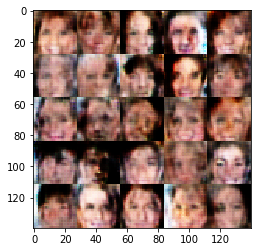

Epoch 1/1... Discriminator Loss: 0.5639... Generator Loss: 1.9490
Epoch 1/1... Discriminator Loss: 0.4527... Generator Loss: 2.8253
Epoch 1/1... Discriminator Loss: 0.3910... Generator Loss: 3.3334
Epoch 1/1... Discriminator Loss: 0.4006... Generator Loss: 3.1108
Epoch 1/1... Discriminator Loss: 0.4733... Generator Loss: 3.7295
Epoch 1/1... Discriminator Loss: 0.3729... Generator Loss: 3.5699
Epoch 1/1... Discriminator Loss: 0.3709... Generator Loss: 3.6212
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.4764
Epoch 1/1... Discriminator Loss: 0.7116... Generator Loss: 1.6664
Epoch 1/1... Discriminator Loss: 1.8162... Generator Loss: 3.6232


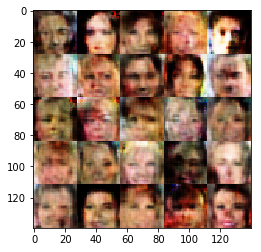

Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 1.0262
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 1.1584
Epoch 1/1... Discriminator Loss: 0.3998... Generator Loss: 3.3925
Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 2.1719
Epoch 1/1... Discriminator Loss: 0.3854... Generator Loss: 3.2641
Epoch 1/1... Discriminator Loss: 0.6689... Generator Loss: 1.5150
Epoch 1/1... Discriminator Loss: 0.6866... Generator Loss: 1.4954
Epoch 1/1... Discriminator Loss: 1.0176... Generator Loss: 2.9979
Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 2.0066
Epoch 1/1... Discriminator Loss: 0.5484... Generator Loss: 2.2659


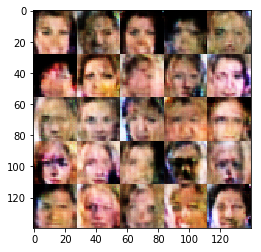

Epoch 1/1... Discriminator Loss: 0.7273... Generator Loss: 1.2818
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 1.5893... Generator Loss: 2.8045
Epoch 1/1... Discriminator Loss: 0.5984... Generator Loss: 3.4773
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 0.7273... Generator Loss: 1.2142
Epoch 1/1... Discriminator Loss: 0.7420... Generator Loss: 1.3240
Epoch 1/1... Discriminator Loss: 0.4957... Generator Loss: 2.5237
Epoch 1/1... Discriminator Loss: 0.4288... Generator Loss: 3.8606
Epoch 1/1... Discriminator Loss: 0.8538... Generator Loss: 3.2553


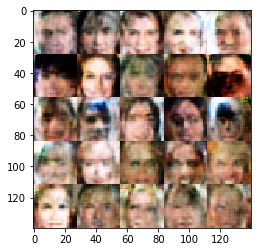

Epoch 1/1... Discriminator Loss: 0.4541... Generator Loss: 2.7759
Epoch 1/1... Discriminator Loss: 0.3888... Generator Loss: 3.3046
Epoch 1/1... Discriminator Loss: 4.0194... Generator Loss: 4.5519
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 1.2718
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 2.3545
Epoch 1/1... Discriminator Loss: 0.4377... Generator Loss: 2.7934
Epoch 1/1... Discriminator Loss: 0.5512... Generator Loss: 1.7969
Epoch 1/1... Discriminator Loss: 0.4521... Generator Loss: 2.8559
Epoch 1/1... Discriminator Loss: 0.8115... Generator Loss: 1.9996


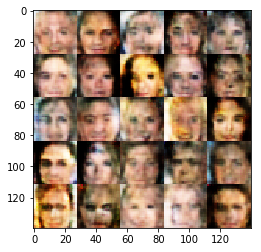

Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 3.1150
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 3.1251
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 1.5411
Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 1.2606
Epoch 1/1... Discriminator Loss: 1.8177... Generator Loss: 0.3146
Epoch 1/1... Discriminator Loss: 0.6844... Generator Loss: 2.0093
Epoch 1/1... Discriminator Loss: 0.6770... Generator Loss: 1.5332
Epoch 1/1... Discriminator Loss: 0.5822... Generator Loss: 1.7278
Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 2.0774


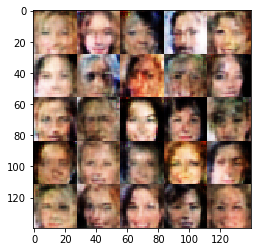

Epoch 1/1... Discriminator Loss: 0.4002... Generator Loss: 2.9512
Epoch 1/1... Discriminator Loss: 0.7411... Generator Loss: 1.8152
Epoch 1/1... Discriminator Loss: 0.7754... Generator Loss: 1.6380
Epoch 1/1... Discriminator Loss: 0.4950... Generator Loss: 2.2887
Epoch 1/1... Discriminator Loss: 0.7345... Generator Loss: 1.5305
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 2.1627
Epoch 1/1... Discriminator Loss: 0.4730... Generator Loss: 2.4705
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 0.7979... Generator Loss: 1.3852
Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 1.2096


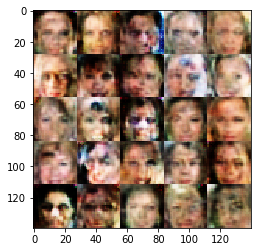

Epoch 1/1... Discriminator Loss: 0.4949... Generator Loss: 2.3395
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.4983
Epoch 1/1... Discriminator Loss: 0.5789... Generator Loss: 1.7639
Epoch 1/1... Discriminator Loss: 0.5827... Generator Loss: 3.1833
Epoch 1/1... Discriminator Loss: 1.6496... Generator Loss: 0.3791
Epoch 1/1... Discriminator Loss: 0.5458... Generator Loss: 1.7995
Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 0.5546... Generator Loss: 2.7917
Epoch 1/1... Discriminator Loss: 0.9103... Generator Loss: 1.0379
Epoch 1/1... Discriminator Loss: 0.9381... Generator Loss: 0.9098


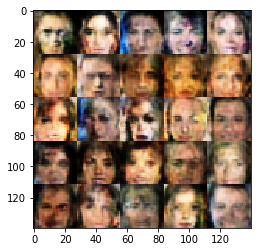

Epoch 1/1... Discriminator Loss: 0.4781... Generator Loss: 3.6046
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 1.3015
Epoch 1/1... Discriminator Loss: 0.8926... Generator Loss: 1.5643
Epoch 1/1... Discriminator Loss: 0.5388... Generator Loss: 2.7262
Epoch 1/1... Discriminator Loss: 0.5634... Generator Loss: 1.9052
Epoch 1/1... Discriminator Loss: 0.6229... Generator Loss: 4.1257
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 0.4560... Generator Loss: 3.1701
Epoch 1/1... Discriminator Loss: 0.4244... Generator Loss: 2.9695


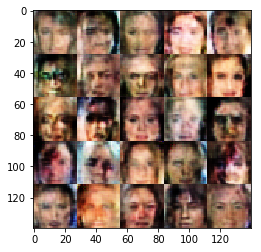

Epoch 1/1... Discriminator Loss: 0.6808... Generator Loss: 1.5287
Epoch 1/1... Discriminator Loss: 0.4271... Generator Loss: 3.8164
Epoch 1/1... Discriminator Loss: 0.5475... Generator Loss: 2.7307
Epoch 1/1... Discriminator Loss: 0.4783... Generator Loss: 2.2620
Epoch 1/1... Discriminator Loss: 0.6602... Generator Loss: 1.7071
Epoch 1/1... Discriminator Loss: 0.6571... Generator Loss: 1.5922
Epoch 1/1... Discriminator Loss: 0.5429... Generator Loss: 1.8055
Epoch 1/1... Discriminator Loss: 0.5153... Generator Loss: 2.0306
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 0.9888
Epoch 1/1... Discriminator Loss: 0.4276... Generator Loss: 2.7389


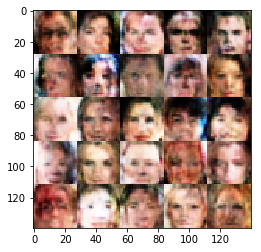

Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 0.7771... Generator Loss: 1.3521
Epoch 1/1... Discriminator Loss: 0.8291... Generator Loss: 1.1490
Epoch 1/1... Discriminator Loss: 0.8162... Generator Loss: 1.0604
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 5.0639
Epoch 1/1... Discriminator Loss: 0.6365... Generator Loss: 1.8351
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 2.4131
Epoch 1/1... Discriminator Loss: 0.6439... Generator Loss: 1.5321
Epoch 1/1... Discriminator Loss: 0.5854... Generator Loss: 2.1410


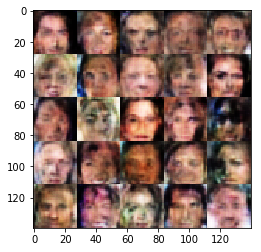

Epoch 1/1... Discriminator Loss: 0.5038... Generator Loss: 2.7902
Epoch 1/1... Discriminator Loss: 0.4085... Generator Loss: 3.5282
Epoch 1/1... Discriminator Loss: 0.6958... Generator Loss: 1.5516
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 2.5309
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 2.0754
Epoch 1/1... Discriminator Loss: 0.5451... Generator Loss: 2.1152
Epoch 1/1... Discriminator Loss: 0.7618... Generator Loss: 1.1713
Epoch 1/1... Discriminator Loss: 0.5410... Generator Loss: 1.9793
Epoch 1/1... Discriminator Loss: 2.5936... Generator Loss: 4.3333
Epoch 1/1... Discriminator Loss: 0.7268... Generator Loss: 3.4041


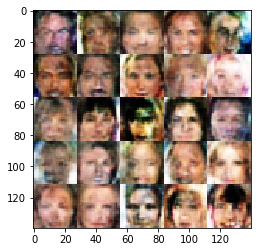

Epoch 1/1... Discriminator Loss: 0.6566... Generator Loss: 1.5718
Epoch 1/1... Discriminator Loss: 0.4838... Generator Loss: 2.2594
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 2.7012
Epoch 1/1... Discriminator Loss: 0.3912... Generator Loss: 3.1674
Epoch 1/1... Discriminator Loss: 0.3884... Generator Loss: 3.4948
Epoch 1/1... Discriminator Loss: 0.3655... Generator Loss: 3.7286
Epoch 1/1... Discriminator Loss: 0.4234... Generator Loss: 3.2311
Epoch 1/1... Discriminator Loss: 0.9401... Generator Loss: 1.4242
Epoch 1/1... Discriminator Loss: 1.6450... Generator Loss: 0.4063
Epoch 1/1... Discriminator Loss: 0.5293... Generator Loss: 2.0789


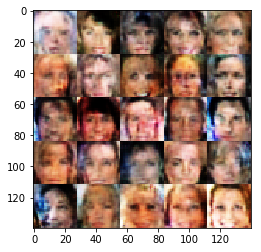

Epoch 1/1... Discriminator Loss: 0.3849... Generator Loss: 3.4673
Epoch 1/1... Discriminator Loss: 0.3477... Generator Loss: 5.0051
Epoch 1/1... Discriminator Loss: 0.6166... Generator Loss: 1.8114
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 1.0298
Epoch 1/1... Discriminator Loss: 0.6525... Generator Loss: 2.1153
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.6125... Generator Loss: 2.8835
Epoch 1/1... Discriminator Loss: 0.4087... Generator Loss: 3.4402
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 4.0144
Epoch 1/1... Discriminator Loss: 2.9413... Generator Loss: 2.5237


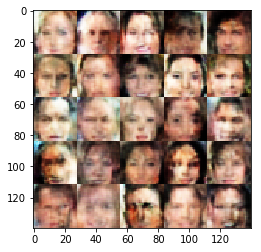

Epoch 1/1... Discriminator Loss: 0.7226... Generator Loss: 3.6608
Epoch 1/1... Discriminator Loss: 0.3571... Generator Loss: 4.1440
Epoch 1/1... Discriminator Loss: 0.5142... Generator Loss: 2.3389
Epoch 1/1... Discriminator Loss: 0.7606... Generator Loss: 2.4045
Epoch 1/1... Discriminator Loss: 0.4023... Generator Loss: 3.2457
Epoch 1/1... Discriminator Loss: 0.5171... Generator Loss: 2.7278
Epoch 1/1... Discriminator Loss: 0.3676... Generator Loss: 4.0388
Epoch 1/1... Discriminator Loss: 0.4544... Generator Loss: 2.4749
Epoch 1/1... Discriminator Loss: 1.6955... Generator Loss: 0.4541
Epoch 1/1... Discriminator Loss: 0.7748... Generator Loss: 3.5752


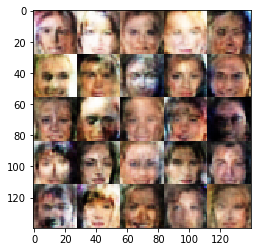

Epoch 1/1... Discriminator Loss: 0.7357... Generator Loss: 1.6271
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 0.5643... Generator Loss: 1.7820
Epoch 1/1... Discriminator Loss: 0.3829... Generator Loss: 3.3008
Epoch 1/1... Discriminator Loss: 0.4046... Generator Loss: 3.1377
Epoch 1/1... Discriminator Loss: 0.3807... Generator Loss: 3.4769
Epoch 1/1... Discriminator Loss: 0.6799... Generator Loss: 1.5597
Epoch 1/1... Discriminator Loss: 0.8768... Generator Loss: 2.7921
Epoch 1/1... Discriminator Loss: 0.4813... Generator Loss: 2.2789
Epoch 1/1... Discriminator Loss: 0.4051... Generator Loss: 3.4599


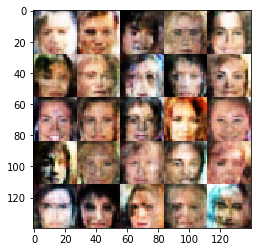

Epoch 1/1... Discriminator Loss: 0.3900... Generator Loss: 3.3068
Epoch 1/1... Discriminator Loss: 0.4447... Generator Loss: 2.5003
Epoch 1/1... Discriminator Loss: 0.5428... Generator Loss: 3.2608
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 0.4470... Generator Loss: 2.6683
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.5490
Epoch 1/1... Discriminator Loss: 0.4645... Generator Loss: 3.3714
Epoch 1/1... Discriminator Loss: 0.4271... Generator Loss: 2.6887
Epoch 1/1... Discriminator Loss: 0.5460... Generator Loss: 3.9241
Epoch 1/1... Discriminator Loss: 0.7150... Generator Loss: 1.4718


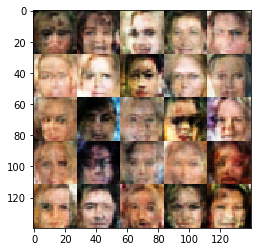

Epoch 1/1... Discriminator Loss: 0.5101... Generator Loss: 3.2189
Epoch 1/1... Discriminator Loss: 0.4691... Generator Loss: 2.4079
Epoch 1/1... Discriminator Loss: 0.9344... Generator Loss: 0.9863
Epoch 1/1... Discriminator Loss: 0.4059... Generator Loss: 2.9323
Epoch 1/1... Discriminator Loss: 0.3694... Generator Loss: 3.6422
Epoch 1/1... Discriminator Loss: 0.4624... Generator Loss: 2.5502
Epoch 1/1... Discriminator Loss: 0.8665... Generator Loss: 6.1667
Epoch 1/1... Discriminator Loss: 0.4701... Generator Loss: 2.5748
Epoch 1/1... Discriminator Loss: 0.3802... Generator Loss: 3.5713
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 5.6357


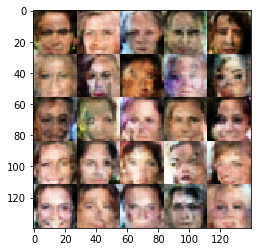

Epoch 1/1... Discriminator Loss: 0.3865... Generator Loss: 3.5000
Epoch 1/1... Discriminator Loss: 0.4402... Generator Loss: 3.4124
Epoch 1/1... Discriminator Loss: 0.9918... Generator Loss: 1.2037
Epoch 1/1... Discriminator Loss: 0.7240... Generator Loss: 1.5609
Epoch 1/1... Discriminator Loss: 0.4505... Generator Loss: 3.1319
Epoch 1/1... Discriminator Loss: 0.4407... Generator Loss: 2.7721
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 0.3919... Generator Loss: 3.4461
Epoch 1/1... Discriminator Loss: 0.6254... Generator Loss: 1.7360
Epoch 1/1... Discriminator Loss: 0.6846... Generator Loss: 5.9319


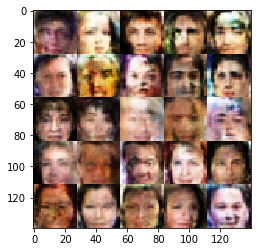

Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 1.0388
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.5666
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 0.6518... Generator Loss: 1.6102
Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 1.8674
Epoch 1/1... Discriminator Loss: 0.5410... Generator Loss: 2.6152
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 0.9083
Epoch 1/1... Discriminator Loss: 0.7422... Generator Loss: 1.3455
Epoch 1/1... Discriminator Loss: 0.5957... Generator Loss: 1.6607


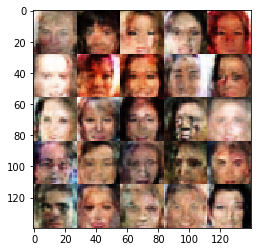

Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 3.2352
Epoch 1/1... Discriminator Loss: 0.4646... Generator Loss: 2.3118
Epoch 1/1... Discriminator Loss: 0.4252... Generator Loss: 3.2781
Epoch 1/1... Discriminator Loss: 1.6367... Generator Loss: 3.5995
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 3.6841
Epoch 1/1... Discriminator Loss: 0.4347... Generator Loss: 3.7733
Epoch 1/1... Discriminator Loss: 0.5501... Generator Loss: 3.8763
Epoch 1/1... Discriminator Loss: 0.4479... Generator Loss: 2.7555
Epoch 1/1... Discriminator Loss: 0.4124... Generator Loss: 3.9923
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 4.0605


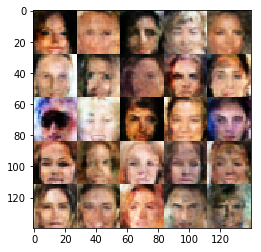

Epoch 1/1... Discriminator Loss: 0.4554... Generator Loss: 2.9361
Epoch 1/1... Discriminator Loss: 0.4193... Generator Loss: 3.0537
Epoch 1/1... Discriminator Loss: 0.7110... Generator Loss: 1.4452
Epoch 1/1... Discriminator Loss: 0.4654... Generator Loss: 2.2716
Epoch 1/1... Discriminator Loss: 0.4745... Generator Loss: 2.4261
Epoch 1/1... Discriminator Loss: 0.4296... Generator Loss: 2.8306
Epoch 1/1... Discriminator Loss: 0.6318... Generator Loss: 1.6123
Epoch 1/1... Discriminator Loss: 0.3748... Generator Loss: 4.0280
Epoch 1/1... Discriminator Loss: 0.8082... Generator Loss: 1.1489
Epoch 1/1... Discriminator Loss: 0.4665... Generator Loss: 2.5231


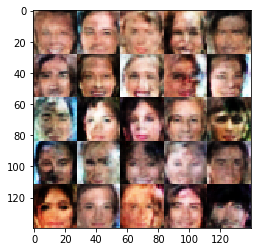

Epoch 1/1... Discriminator Loss: 0.4393... Generator Loss: 2.6813
Epoch 1/1... Discriminator Loss: 0.4284... Generator Loss: 3.6567
Epoch 1/1... Discriminator Loss: 0.3874... Generator Loss: 3.2967
Epoch 1/1... Discriminator Loss: 0.4559... Generator Loss: 4.2725
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 6.3029
Epoch 1/1... Discriminator Loss: 0.6342... Generator Loss: 2.0028
Epoch 1/1... Discriminator Loss: 0.3839... Generator Loss: 3.2822
Epoch 1/1... Discriminator Loss: 0.4783... Generator Loss: 3.6057
Epoch 1/1... Discriminator Loss: 0.3836... Generator Loss: 3.4082
Epoch 1/1... Discriminator Loss: 0.4036... Generator Loss: 4.2075


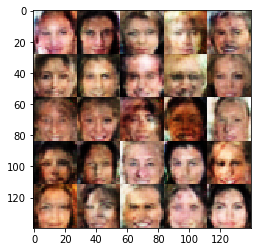

Epoch 1/1... Discriminator Loss: 0.7075... Generator Loss: 1.8141
Epoch 1/1... Discriminator Loss: 1.6914... Generator Loss: 0.4851
Epoch 1/1... Discriminator Loss: 0.5178... Generator Loss: 2.0082
Epoch 1/1... Discriminator Loss: 0.6887... Generator Loss: 4.6761
Epoch 1/1... Discriminator Loss: 0.3783... Generator Loss: 4.0128
Epoch 1/1... Discriminator Loss: 0.3632... Generator Loss: 5.1061
Epoch 1/1... Discriminator Loss: 0.4305... Generator Loss: 3.1711
Epoch 1/1... Discriminator Loss: 0.6449... Generator Loss: 4.3727
Epoch 1/1... Discriminator Loss: 0.3674... Generator Loss: 4.1246
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 5.6687


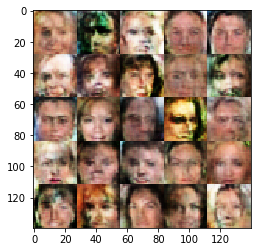

Epoch 1/1... Discriminator Loss: 0.7079... Generator Loss: 1.5558
Epoch 1/1... Discriminator Loss: 0.8114... Generator Loss: 3.1594
Epoch 1/1... Discriminator Loss: 2.3900... Generator Loss: 4.7412
Epoch 1/1... Discriminator Loss: 0.4265... Generator Loss: 3.2685
Epoch 1/1... Discriminator Loss: 0.5804... Generator Loss: 1.9652
Epoch 1/1... Discriminator Loss: 0.3551... Generator Loss: 4.7363
Epoch 1/1... Discriminator Loss: 0.4579... Generator Loss: 5.7440
Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.4351
Epoch 1/1... Discriminator Loss: 0.3866... Generator Loss: 3.3222
Epoch 1/1... Discriminator Loss: 0.7681... Generator Loss: 1.8687


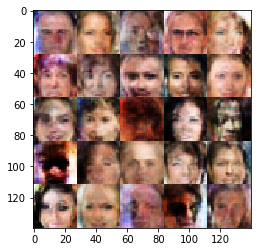

Epoch 1/1... Discriminator Loss: 0.9411... Generator Loss: 1.0098
Epoch 1/1... Discriminator Loss: 0.5722... Generator Loss: 2.2847
Epoch 1/1... Discriminator Loss: 0.6006... Generator Loss: 1.7728
Epoch 1/1... Discriminator Loss: 0.4006... Generator Loss: 3.8200
Epoch 1/1... Discriminator Loss: 0.6846... Generator Loss: 4.9331
Epoch 1/1... Discriminator Loss: 0.5013... Generator Loss: 5.5263
Epoch 1/1... Discriminator Loss: 0.8601... Generator Loss: 1.0820
Epoch 1/1... Discriminator Loss: 0.5599... Generator Loss: 2.1929
Epoch 1/1... Discriminator Loss: 0.3763... Generator Loss: 3.9478
Epoch 1/1... Discriminator Loss: 0.3586... Generator Loss: 4.3028


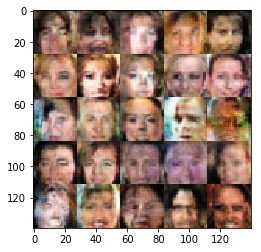

Epoch 1/1... Discriminator Loss: 0.5558... Generator Loss: 1.9715
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 3.7941
Epoch 1/1... Discriminator Loss: 0.6556... Generator Loss: 1.4786
Epoch 1/1... Discriminator Loss: 0.5392... Generator Loss: 1.9451
Epoch 1/1... Discriminator Loss: 0.3700... Generator Loss: 3.9546
Epoch 1/1... Discriminator Loss: 0.3647... Generator Loss: 4.8477
Epoch 1/1... Discriminator Loss: 0.5069... Generator Loss: 2.7076
Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 3.9220
Epoch 1/1... Discriminator Loss: 0.5523... Generator Loss: 1.8972
Epoch 1/1... Discriminator Loss: 1.6840... Generator Loss: 3.3089


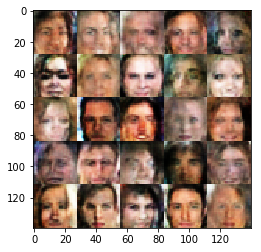

Epoch 1/1... Discriminator Loss: 0.4326... Generator Loss: 2.9489
Epoch 1/1... Discriminator Loss: 0.5555... Generator Loss: 2.0135
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 0.4009... Generator Loss: 3.4087
Epoch 1/1... Discriminator Loss: 0.3971... Generator Loss: 3.0798
Epoch 1/1... Discriminator Loss: 0.4008... Generator Loss: 4.8391
Epoch 1/1... Discriminator Loss: 0.4295... Generator Loss: 4.1386
Epoch 1/1... Discriminator Loss: 0.3521... Generator Loss: 4.7111
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 2.7095
Epoch 1/1... Discriminator Loss: 0.3722... Generator Loss: 4.1757


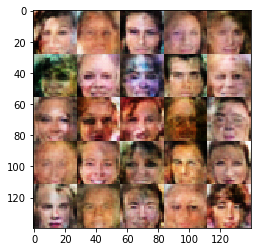

Epoch 1/1... Discriminator Loss: 0.4029... Generator Loss: 5.0936
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 0.4223... Generator Loss: 3.3473
Epoch 1/1... Discriminator Loss: 0.4402... Generator Loss: 3.0136
Epoch 1/1... Discriminator Loss: 0.3429... Generator Loss: 5.5476
Epoch 1/1... Discriminator Loss: 2.2145... Generator Loss: 0.2926
Epoch 1/1... Discriminator Loss: 0.4542... Generator Loss: 2.5751
Epoch 1/1... Discriminator Loss: 0.4008... Generator Loss: 4.0071
Epoch 1/1... Discriminator Loss: 0.6354... Generator Loss: 2.3004
Epoch 1/1... Discriminator Loss: 0.3559... Generator Loss: 4.2852


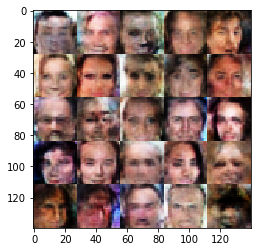

Epoch 1/1... Discriminator Loss: 0.7050... Generator Loss: 1.6474
Epoch 1/1... Discriminator Loss: 0.3899... Generator Loss: 4.1067
Epoch 1/1... Discriminator Loss: 0.4662... Generator Loss: 3.4871
Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 2.7787
Epoch 1/1... Discriminator Loss: 0.3542... Generator Loss: 4.1671
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 3.5451
Epoch 1/1... Discriminator Loss: 0.5104... Generator Loss: 2.1274
Epoch 1/1... Discriminator Loss: 0.4578... Generator Loss: 2.9763
Epoch 1/1... Discriminator Loss: 0.3522... Generator Loss: 4.6655
Epoch 1/1... Discriminator Loss: 0.3685... Generator Loss: 3.8848


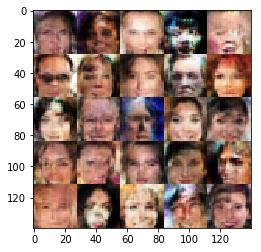

Epoch 1/1... Discriminator Loss: 0.3637... Generator Loss: 4.1986
Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 3.6021
Epoch 1/1... Discriminator Loss: 0.3508... Generator Loss: 4.7744
Epoch 1/1... Discriminator Loss: 1.6584... Generator Loss: 0.3890
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 1.1332
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 0.9562
Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 0.9966
Epoch 1/1... Discriminator Loss: 0.5835... Generator Loss: 1.8476
Epoch 1/1... Discriminator Loss: 0.4355... Generator Loss: 4.0971
Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 3.5429


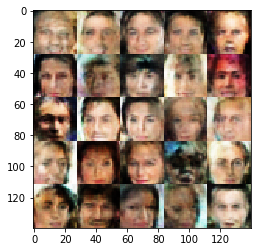

Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 4.5053
Epoch 1/1... Discriminator Loss: 0.3838... Generator Loss: 4.2258
Epoch 1/1... Discriminator Loss: 0.3565... Generator Loss: 4.6664
Epoch 1/1... Discriminator Loss: 0.3575... Generator Loss: 4.7926
Epoch 1/1... Discriminator Loss: 2.4883... Generator Loss: 4.7192
Epoch 1/1... Discriminator Loss: 0.7254... Generator Loss: 1.3161
Epoch 1/1... Discriminator Loss: 0.3866... Generator Loss: 3.7682
Epoch 1/1... Discriminator Loss: 0.5402... Generator Loss: 2.4166
Epoch 1/1... Discriminator Loss: 0.4046... Generator Loss: 3.5545


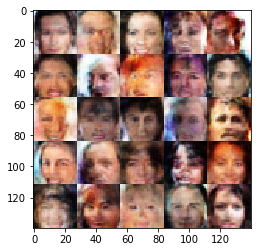

Epoch 1/1... Discriminator Loss: 0.5491... Generator Loss: 2.8504
Epoch 1/1... Discriminator Loss: 0.4808... Generator Loss: 2.1865
Epoch 1/1... Discriminator Loss: 0.3826... Generator Loss: 4.1959
Epoch 1/1... Discriminator Loss: 0.7825... Generator Loss: 6.2583
Epoch 1/1... Discriminator Loss: 0.5165... Generator Loss: 6.6078
Epoch 1/1... Discriminator Loss: 2.5733... Generator Loss: 4.9327
Epoch 1/1... Discriminator Loss: 0.7436... Generator Loss: 2.3009
Epoch 1/1... Discriminator Loss: 0.6091... Generator Loss: 1.6507
Epoch 1/1... Discriminator Loss: 0.6446... Generator Loss: 2.5273
Epoch 1/1... Discriminator Loss: 0.4428... Generator Loss: 3.4353


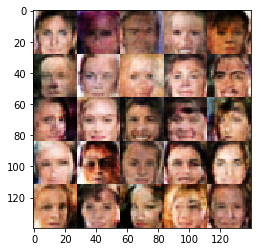

Epoch 1/1... Discriminator Loss: 2.0383... Generator Loss: 0.3131
Epoch 1/1... Discriminator Loss: 0.3935... Generator Loss: 3.3837
Epoch 1/1... Discriminator Loss: 0.8544... Generator Loss: 2.1108
Epoch 1/1... Discriminator Loss: 0.4292... Generator Loss: 2.7178
Epoch 1/1... Discriminator Loss: 0.3896... Generator Loss: 3.9303
Epoch 1/1... Discriminator Loss: 0.3576... Generator Loss: 4.5395
Epoch 1/1... Discriminator Loss: 0.3561... Generator Loss: 4.5918
Epoch 1/1... Discriminator Loss: 0.3575... Generator Loss: 5.3107
Epoch 1/1... Discriminator Loss: 0.3984... Generator Loss: 3.9681
Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 3.2531


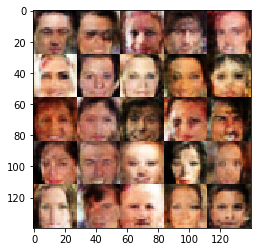

Epoch 1/1... Discriminator Loss: 0.4390... Generator Loss: 4.9927
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 0.9851
Epoch 1/1... Discriminator Loss: 1.6001... Generator Loss: 0.5084
Epoch 1/1... Discriminator Loss: 3.0765... Generator Loss: 0.1294
Epoch 1/1... Discriminator Loss: 0.4697... Generator Loss: 3.1291
Epoch 1/1... Discriminator Loss: 0.4013... Generator Loss: 3.4360
Epoch 1/1... Discriminator Loss: 0.4967... Generator Loss: 2.9652
Epoch 1/1... Discriminator Loss: 0.4153... Generator Loss: 3.5299
Epoch 1/1... Discriminator Loss: 0.7116... Generator Loss: 1.6257
Epoch 1/1... Discriminator Loss: 0.4679... Generator Loss: 2.9264


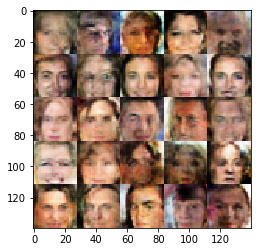

Epoch 1/1... Discriminator Loss: 0.3667... Generator Loss: 3.8063
Epoch 1/1... Discriminator Loss: 0.5231... Generator Loss: 2.5088
Epoch 1/1... Discriminator Loss: 0.3792... Generator Loss: 4.0652
Epoch 1/1... Discriminator Loss: 0.4470... Generator Loss: 2.6813
Epoch 1/1... Discriminator Loss: 0.4083... Generator Loss: 4.0316
Epoch 1/1... Discriminator Loss: 0.3737... Generator Loss: 4.2726
Epoch 1/1... Discriminator Loss: 1.9893... Generator Loss: 5.3167
Epoch 1/1... Discriminator Loss: 0.6849... Generator Loss: 2.9869
Epoch 1/1... Discriminator Loss: 0.4059... Generator Loss: 3.6014
Epoch 1/1... Discriminator Loss: 0.3773... Generator Loss: 4.9796


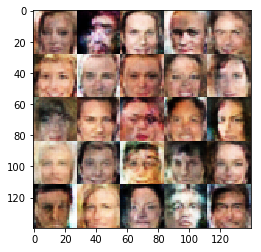

Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 0.4099... Generator Loss: 2.9749
Epoch 1/1... Discriminator Loss: 0.4605... Generator Loss: 2.4853
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 2.9839
Epoch 1/1... Discriminator Loss: 0.7556... Generator Loss: 3.0656
Epoch 1/1... Discriminator Loss: 0.5460... Generator Loss: 1.8832
Epoch 1/1... Discriminator Loss: 0.3980... Generator Loss: 3.4174
Epoch 1/1... Discriminator Loss: 0.5428... Generator Loss: 2.0997
Epoch 1/1... Discriminator Loss: 0.5235... Generator Loss: 2.0115
Epoch 1/1... Discriminator Loss: 0.3655... Generator Loss: 4.2711


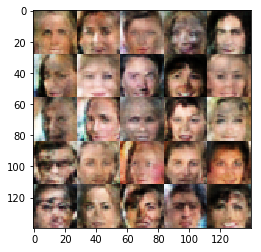

Epoch 1/1... Discriminator Loss: 0.5439... Generator Loss: 1.9095
Epoch 1/1... Discriminator Loss: 0.3869... Generator Loss: 3.5400
Epoch 1/1... Discriminator Loss: 0.3930... Generator Loss: 3.2134
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 5.1570
Epoch 1/1... Discriminator Loss: 0.3953... Generator Loss: 3.3219
Epoch 1/1... Discriminator Loss: 0.4891... Generator Loss: 5.5642
Epoch 1/1... Discriminator Loss: 0.3639... Generator Loss: 4.4576
Epoch 1/1... Discriminator Loss: 0.6363... Generator Loss: 1.6657
Epoch 1/1... Discriminator Loss: 0.3894... Generator Loss: 3.8632
Epoch 1/1... Discriminator Loss: 0.4405... Generator Loss: 2.7593


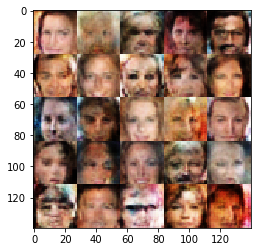

Epoch 1/1... Discriminator Loss: 0.3543... Generator Loss: 5.3873
Epoch 1/1... Discriminator Loss: 0.3779... Generator Loss: 3.6549
Epoch 1/1... Discriminator Loss: 0.4564... Generator Loss: 4.1573
Epoch 1/1... Discriminator Loss: 0.3837... Generator Loss: 3.7467
Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 3.2669
Epoch 1/1... Discriminator Loss: 0.7745... Generator Loss: 1.5752
Epoch 1/1... Discriminator Loss: 0.8126... Generator Loss: 2.3977
Epoch 1/1... Discriminator Loss: 0.4344... Generator Loss: 2.9007
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 0.3891... Generator Loss: 3.3989


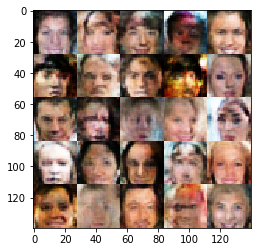

Epoch 1/1... Discriminator Loss: 2.6038... Generator Loss: 5.5154
Epoch 1/1... Discriminator Loss: 0.5256... Generator Loss: 3.1191
Epoch 1/1... Discriminator Loss: 0.4779... Generator Loss: 2.9436
Epoch 1/1... Discriminator Loss: 0.4161... Generator Loss: 3.0597
Epoch 1/1... Discriminator Loss: 2.2055... Generator Loss: 0.2771
Epoch 1/1... Discriminator Loss: 0.3744... Generator Loss: 4.9141
Epoch 1/1... Discriminator Loss: 0.4929... Generator Loss: 4.8728
Epoch 1/1... Discriminator Loss: 0.4055... Generator Loss: 4.5293
Epoch 1/1... Discriminator Loss: 0.4926... Generator Loss: 2.6713
Epoch 1/1... Discriminator Loss: 0.4760... Generator Loss: 2.4844


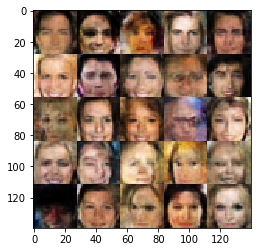

Epoch 1/1... Discriminator Loss: 0.3986... Generator Loss: 3.4713
Epoch 1/1... Discriminator Loss: 0.3952... Generator Loss: 4.4874
Epoch 1/1... Discriminator Loss: 0.3677... Generator Loss: 4.9502
Epoch 1/1... Discriminator Loss: 0.3483... Generator Loss: 4.7314
Epoch 1/1... Discriminator Loss: 0.3481... Generator Loss: 6.0446
Epoch 1/1... Discriminator Loss: 0.4977... Generator Loss: 3.2665
Epoch 1/1... Discriminator Loss: 2.7823... Generator Loss: 0.2133
Epoch 1/1... Discriminator Loss: 0.3980... Generator Loss: 3.4721
Epoch 1/1... Discriminator Loss: 0.4047... Generator Loss: 3.1295
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 2.8720


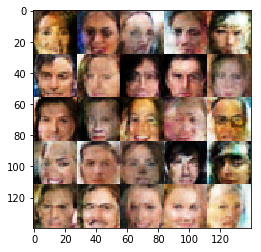

Epoch 1/1... Discriminator Loss: 0.4583... Generator Loss: 2.7307
Epoch 1/1... Discriminator Loss: 0.4068... Generator Loss: 3.3527
Epoch 1/1... Discriminator Loss: 0.4003... Generator Loss: 3.1085
Epoch 1/1... Discriminator Loss: 0.3901... Generator Loss: 4.5602
Epoch 1/1... Discriminator Loss: 0.3864... Generator Loss: 3.3984
Epoch 1/1... Discriminator Loss: 0.3957... Generator Loss: 3.2421
Epoch 1/1... Discriminator Loss: 0.3547... Generator Loss: 5.0380
Epoch 1/1... Discriminator Loss: 1.9575... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 0.4345... Generator Loss: 3.0053
Epoch 1/1... Discriminator Loss: 0.3646... Generator Loss: 4.3258


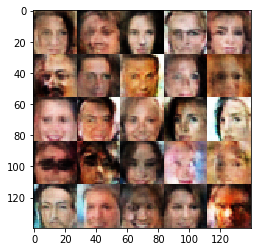

Epoch 1/1... Discriminator Loss: 0.4531... Generator Loss: 6.7447
Epoch 1/1... Discriminator Loss: 0.3785... Generator Loss: 3.7307
Epoch 1/1... Discriminator Loss: 0.4050... Generator Loss: 3.1140
Epoch 1/1... Discriminator Loss: 1.8438... Generator Loss: 4.9156
Epoch 1/1... Discriminator Loss: 0.4313... Generator Loss: 2.8205
Epoch 1/1... Discriminator Loss: 0.3937... Generator Loss: 4.4800
Epoch 1/1... Discriminator Loss: 0.3623... Generator Loss: 5.5952
Epoch 1/1... Discriminator Loss: 0.4023... Generator Loss: 3.7105
Epoch 1/1... Discriminator Loss: 0.3583... Generator Loss: 4.4649
Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 2.4460


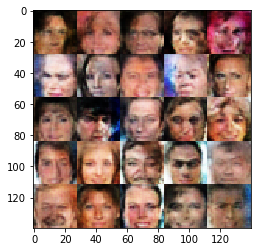

Epoch 1/1... Discriminator Loss: 0.6525... Generator Loss: 1.5407
Epoch 1/1... Discriminator Loss: 0.7922... Generator Loss: 1.1759
Epoch 1/1... Discriminator Loss: 0.6920... Generator Loss: 1.4694
Epoch 1/1... Discriminator Loss: 0.7574... Generator Loss: 1.4238
Epoch 1/1... Discriminator Loss: 0.4610... Generator Loss: 2.7591
Epoch 1/1... Discriminator Loss: 0.3499... Generator Loss: 4.6874
Epoch 1/1... Discriminator Loss: 0.4285... Generator Loss: 3.1797
Epoch 1/1... Discriminator Loss: 0.3713... Generator Loss: 4.7612
Epoch 1/1... Discriminator Loss: 0.3570... Generator Loss: 4.6750
Epoch 1/1... Discriminator Loss: 0.3931... Generator Loss: 4.3499


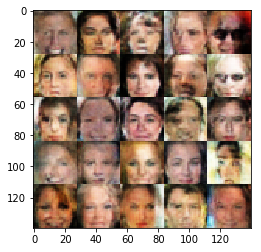

Epoch 1/1... Discriminator Loss: 0.3424... Generator Loss: 5.5477
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 5.5709
Epoch 1/1... Discriminator Loss: 0.5325... Generator Loss: 4.6167
Epoch 1/1... Discriminator Loss: 0.3797... Generator Loss: 4.1316
Epoch 1/1... Discriminator Loss: 0.3802... Generator Loss: 4.9092
Epoch 1/1... Discriminator Loss: 0.5828... Generator Loss: 2.8270
Epoch 1/1... Discriminator Loss: 0.5132... Generator Loss: 2.4330
Epoch 1/1... Discriminator Loss: 0.4764... Generator Loss: 6.2021
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 1.0530
Epoch 1/1... Discriminator Loss: 0.3851... Generator Loss: 3.2949


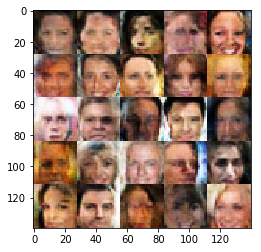

Epoch 1/1... Discriminator Loss: 0.3562... Generator Loss: 6.2607
Epoch 1/1... Discriminator Loss: 1.7979... Generator Loss: 0.3692
Epoch 1/1... Discriminator Loss: 0.8191... Generator Loss: 3.3322


In [13]:
batch_size = 32
z_dim = 64
learning_rate = 1e-3
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.